In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import cupy as cp
import math
from cupy.cuda.nvtx import RangePush, RangePop
from tqdm import tqdm
import time

In [2]:
file = h5py.File("data.mat")

#load data
xscanSize, yscanSize = int(file["pyStrE"]["xscanSize"][0,0]), int(file["pyStrE"]["yscanSize"][0,0])
resolutionX, resolutionY = file["pyStrE"]["resolutionX"][0,0], file["pyStrE"]["resolutionY"][0,0]
Xsize, Ysize = file["pyStrE"]["arraySizeX"][:], file["pyStrE"]["arraySizeY"]
objArraySizeX, objArraySizeY = int(file["pyStrE"]["objArraySizeX"][0,0]), int(file["pyStrE"]["objArraySizeY"][0,0])
prbArraySizeX, prbArraySizeY = int(file["pyStrE"]["prbArraySizeX"][0,0]), int(file["pyStrE"]["prbArraySizeY"][0,0])
xList, yList = file["pyStrE"]["xList"][:], file["pyStrE"]["yList"][:] 
alpha, beta = file["ePIEstr"]["alpha"][0,0], file["ePIEstr"]["beta"][0,0]


object_rot = cp.asarray(file["object_rot"][:].view(np.complex128)) 
probe_ini = cp.asarray(file["probe"][:].view(np.complex128)) 

angle = file["angle"]

In [3]:
CDIstack = cp.asarray(file["CDIstack"][:,:,:,:,:]) #take a lot of time
print(CDIstack.shape)

(181, 11, 11, 514, 514)


In [3]:
#画像181枚分の再構成
object = object_rot.copy()
probe = probe_ini.copy()
num_pictures = xList.shape[0]
print(num_pictures)

181


In [14]:
#画像再構成の関数を定義
@cp.fuse
def inv_space_constraint(DELTAwave, CDIstack): #逆空間拘束
    DELTAwave[:] = cp.where(CDIstack >= 0,
                            cp.sqrt(CDIstack) * cp.where(cp.abs(DELTAwave) == 0,
                                                         DELTAwave,
                                                         DELTAwave / cp.sqrt(cp.abs(DELTAwave))),
                            DELTAwave)

#@cp.fuse
def maxabs2(x): #xの複素数の絶対値の最大値をかえす　
    return cp.max(x * cp.conj(x))
    
@cp.fuse
def update(A, coef, B, msa, DELTAwave): #更新式のアップデート
    A += (coef / msa) * cp.conj(B) * DELTAwave
    
@cp.fuse 
def rfactor_nom(CDIstack, DELTAwave_org): #rfactor正規化
    return cp.square(cp.where(CDIstack >= 0, cp.square(CDIstack) - cp.square(cp.abs(DELTAwave_org)), 0))

@cp.fuse
def rfactor_denom(CDIstack): #rfactor非正規化
    return cp.where(CDIstack >= 0, cp.square(cp.square(CDIstack)), 0)

In [15]:
all_object = []
all_rfactors = []
total_time = 0

#画像の枚数ループ

for i in range(num_pictures):
    #画像1枚分の再構成を行う

    #画像1枚用の変数の準備
    object_1 = object[i,0,:,:]
    probe_1 = probe[i,0,:,:]
    Xsize_1 = Xsize[i,0] 
    Ysize_1 = Ysize[i,0] 
    xList_1 = xList[i,:,:] 
    yList_1 = yList[i,:,:] 
    CDIstack_1 = cp.fft.fftshift(CDIstack[i,:,:,:,:], axes=(2,3))

    Xa = math.floor(prbArraySizeX / 2) - math.floor(Xsize_1 / 2) # 457/2 -457/2
    Xb = Xa + Xsize_1 # 0+457
    Ya = math.floor(prbArraySizeY / 2) - math.floor(Ysize_1 / 2)
    Yb = Ya + Ysize_1

    rfactors = []

    start = time.time()

    with cp.cuda.Stream(non_blocking=True) as stream:     
        #2次元fftの計算 probe×objectのfft probe[0-457] object[457,457]
        DELTAwave_org = cp.fft.fft2(probe_1[Xa:Xb, Ya:Yb] * object_1[:Xsize_1, :Ysize_1], norm="ortho")

        stream.begin_capture()

        nominator = cp.array(0.0)
        denominator = cp.array(0.0)
        probe_org = probe_1.copy()
        object_org = object_1.copy()
        
        for j in range(xscanSize * yscanSize): #11*11
            Xn, Yn = divmod(j, xscanSize)      
            X1 = int(xList_1[Yn, Xn] / resolutionX) + math.floor(objArraySizeX / 2) - math.floor(Xsize_1 / 2)
            X2 = X1 + Xsize_1
            Y1 = int(yList_1[Yn, Xn] / resolutionY) + math.floor(objArraySizeY / 2) - math.floor(Ysize_1 / 2)
            Y2 = Y1 + Ysize_1

            INwave = probe_1[Xa:Xb, Ya:Yb]
            S_object = object_1[X1:X2, Y1:Y2]

            # Forward propagation 順伝播
            RangePush("Forward propagation")
            OUTwave = INwave * S_object
            DELTAwave = cp.fft.fft2(OUTwave, norm="ortho")
            RangePop()

            # R-factor
            RangePush("R-factor")
            OUTWave_org = probe_org[Xa:Xb, Ya:Yb] * object_org[X1:X2, Y1:Y2]
            DELTAwave_org = cp.fft.fft2(OUTWave_org, norm="ortho")
            nominator += cp.sum(rfactor_nom(CDIstack_1[Yn, Xn, Xa:Xb, Ya:Yb], DELTAwave_org))
            denominator += cp.sum(rfactor_denom(CDIstack_1[Yn, Xn, Xa:Xb, Ya:Yb]))
            RangePop()
            
            # Inverse-space constraint 逆空間拘束
            RangePush("Inverse-space constraint")
            inv_space_constraint(DELTAwave, CDIstack_1[Yn, Xn, Xa:Xb, Ya:Yb])
            RangePop()

            # Backward propagation 逆伝播
            RangePush("Backward propagation")
            DELTAwave = cp.fft.ifft2(DELTAwave, norm="ortho") - OUTwave
            S_object_old = S_object.copy()
            update(S_object, alpha, INwave, maxabs2(INwave), DELTAwave)
            # 制約条件 
            S_object = cp.abs(S_object) * cp.exp(cp.where(S_object > math.pi, math.pi, S_object))


            update(INwave, beta, S_object_old, maxabs2(S_object_old), DELTAwave)
            RangePop()

        graph = stream.end_capture()

        print("picture: "+str(i+1)+"/"+str(num_pictures))
        for _ in tqdm(range(200)):
            graph.launch(stream)
            stream.synchronize()
            rfactors.append((nominator / denominator).item())

        end = time.time()

    all_object.append(object_1)
    all_rfactors.append(rfactors)
    Elapsed = end - start
    total_time = total_time + Elapsed

    print("Elapsed:", end - start)
print("Total_time:",total_time)


(514, 514)
picture: 1/181


100%|██████████| 200/200 [00:08<00:00, 24.82it/s]


Elapsed: 8.27472710609436
(514, 514)
picture: 2/181


100%|██████████| 200/200 [00:08<00:00, 24.71it/s]


Elapsed: 8.21739912033081
(514, 514)
picture: 3/181


100%|██████████| 200/200 [00:08<00:00, 24.86it/s]


Elapsed: 8.16370439529419
(514, 514)
picture: 4/181


100%|██████████| 200/200 [00:08<00:00, 24.80it/s]


Elapsed: 8.179381847381592
(514, 514)
picture: 5/181


100%|██████████| 200/200 [00:08<00:00, 24.81it/s]


Elapsed: 8.176401376724243
(514, 514)
picture: 6/181


100%|██████████| 200/200 [00:08<00:00, 24.73it/s]


Elapsed: 8.203102588653564
(514, 514)
picture: 7/181


100%|██████████| 200/200 [00:08<00:00, 24.84it/s]


Elapsed: 8.167539119720459
(514, 514)
picture: 8/181


100%|██████████| 200/200 [00:08<00:00, 24.78it/s]


Elapsed: 8.186441421508789
(514, 514)
picture: 9/181


100%|██████████| 200/200 [00:08<00:00, 24.75it/s]


Elapsed: 8.195442199707031
(514, 514)
picture: 10/181


100%|██████████| 200/200 [00:08<00:00, 24.66it/s]


Elapsed: 8.225926399230957
(514, 514)
picture: 11/181


100%|██████████| 200/200 [00:08<00:00, 24.75it/s]


Elapsed: 8.196502447128296
(514, 514)
picture: 12/181


100%|██████████| 200/200 [00:08<00:00, 24.78it/s]


Elapsed: 8.186864614486694
(514, 514)
picture: 13/181


100%|██████████| 200/200 [00:08<00:00, 24.77it/s]


Elapsed: 8.192603349685669
(514, 514)
picture: 14/181


100%|██████████| 200/200 [00:08<00:00, 24.66it/s]


Elapsed: 8.224727869033813
(514, 514)
picture: 15/181


100%|██████████| 200/200 [00:08<00:00, 24.82it/s]


Elapsed: 8.172317266464233
(514, 514)
picture: 16/181


100%|██████████| 200/200 [00:08<00:00, 24.68it/s]


Elapsed: 8.219339370727539
(514, 514)
picture: 17/181


100%|██████████| 200/200 [00:08<00:00, 24.85it/s]


Elapsed: 8.164239645004272
(514, 514)
picture: 18/181


100%|██████████| 200/200 [00:08<00:00, 24.78it/s]


Elapsed: 8.187912702560425
(514, 514)
picture: 19/181


100%|██████████| 200/200 [00:08<00:00, 24.86it/s]


Elapsed: 8.159667491912842
(514, 514)
picture: 20/181


100%|██████████| 200/200 [00:08<00:00, 24.68it/s]


Elapsed: 8.221484899520874
(514, 514)
picture: 21/181


100%|██████████| 200/200 [00:08<00:00, 24.83it/s]


Elapsed: 8.169684648513794
(514, 514)
picture: 22/181


100%|██████████| 200/200 [00:08<00:00, 24.73it/s]


Elapsed: 8.20296597480774
(514, 514)
picture: 23/181


100%|██████████| 200/200 [00:08<00:00, 24.86it/s]


Elapsed: 8.160205841064453
(514, 514)
picture: 24/181


100%|██████████| 200/200 [00:08<00:00, 24.76it/s]


Elapsed: 8.193645238876343
(514, 514)
picture: 25/181


100%|██████████| 200/200 [00:08<00:00, 24.76it/s]


Elapsed: 8.191874742507935
(514, 514)
picture: 26/181


100%|██████████| 200/200 [00:08<00:00, 24.85it/s]


Elapsed: 8.16287636756897
(514, 514)
picture: 27/181


100%|██████████| 200/200 [00:08<00:00, 24.81it/s]


Elapsed: 8.174801349639893
(514, 514)
picture: 28/181


100%|██████████| 200/200 [00:08<00:00, 24.83it/s]


Elapsed: 8.171269416809082
(514, 514)
picture: 29/181


100%|██████████| 200/200 [00:08<00:00, 24.79it/s]


Elapsed: 8.182865858078003
(514, 514)
picture: 30/181


100%|██████████| 200/200 [00:08<00:00, 24.72it/s]


Elapsed: 8.206287860870361
(514, 514)
picture: 31/181


100%|██████████| 200/200 [00:08<00:00, 24.89it/s]


Elapsed: 8.151848316192627
(514, 514)
picture: 32/181


100%|██████████| 200/200 [00:08<00:00, 24.76it/s]


Elapsed: 8.193603038787842
(514, 514)
picture: 33/181


100%|██████████| 200/200 [00:08<00:00, 24.90it/s]


Elapsed: 8.148283004760742
(514, 514)
picture: 34/181


100%|██████████| 200/200 [00:08<00:00, 24.75it/s]


Elapsed: 8.196377038955688
(514, 514)
picture: 35/181


100%|██████████| 200/200 [00:08<00:00, 24.88it/s]


Elapsed: 8.153132915496826
(514, 514)
picture: 36/181


100%|██████████| 200/200 [00:08<00:00, 24.73it/s]


Elapsed: 8.207317113876343
(514, 514)
picture: 37/181


100%|██████████| 200/200 [00:08<00:00, 24.87it/s]


Elapsed: 8.155996322631836
(514, 514)
picture: 38/181


100%|██████████| 200/200 [00:08<00:00, 24.83it/s]


Elapsed: 8.17003870010376
(514, 514)
picture: 39/181


100%|██████████| 200/200 [00:08<00:00, 24.80it/s]


Elapsed: 8.178985595703125
(514, 514)
picture: 40/181


100%|██████████| 200/200 [00:08<00:00, 24.71it/s]


Elapsed: 8.208860874176025
(514, 514)
picture: 41/181


100%|██████████| 200/200 [00:08<00:00, 24.81it/s]


Elapsed: 8.18229866027832
(514, 514)
picture: 42/181


100%|██████████| 200/200 [00:08<00:00, 24.70it/s]


Elapsed: 8.21202039718628
(514, 514)
picture: 43/181


100%|██████████| 200/200 [00:08<00:00, 24.90it/s]


Elapsed: 8.147817850112915
(514, 514)
picture: 44/181


100%|██████████| 200/200 [00:08<00:00, 24.74it/s]


Elapsed: 8.198913812637329
(514, 514)
picture: 45/181


100%|██████████| 200/200 [00:08<00:00, 24.88it/s]


Elapsed: 8.152419567108154
(514, 514)
picture: 46/181


100%|██████████| 200/200 [00:08<00:00, 24.84it/s]


Elapsed: 8.168845415115356
(514, 514)
picture: 47/181


100%|██████████| 200/200 [00:08<00:00, 24.78it/s]


Elapsed: 8.186740398406982
(514, 514)
picture: 48/181


100%|██████████| 200/200 [00:08<00:00, 24.84it/s]


Elapsed: 8.168999433517456
(514, 514)
picture: 49/181


100%|██████████| 200/200 [00:08<00:00, 24.89it/s]


Elapsed: 8.152499675750732
(514, 514)
picture: 50/181


100%|██████████| 200/200 [00:08<00:00, 24.81it/s]


Elapsed: 8.1759192943573
(514, 514)
picture: 51/181


100%|██████████| 200/200 [00:08<00:00, 24.80it/s]


Elapsed: 8.180015563964844
(514, 514)
picture: 52/181


100%|██████████| 200/200 [00:08<00:00, 24.82it/s]


Elapsed: 8.172170400619507
(514, 514)
picture: 53/181


100%|██████████| 200/200 [00:08<00:00, 24.90it/s]


Elapsed: 8.150043964385986
(514, 514)
picture: 54/181


100%|██████████| 200/200 [00:08<00:00, 24.81it/s]


Elapsed: 8.174817323684692
(514, 514)
picture: 55/181


100%|██████████| 200/200 [00:08<00:00, 24.80it/s]


Elapsed: 8.181747198104858
(514, 514)
picture: 56/181


100%|██████████| 200/200 [00:08<00:00, 24.82it/s]


Elapsed: 8.171832084655762
(514, 514)
picture: 57/181


100%|██████████| 200/200 [00:08<00:00, 24.77it/s]


Elapsed: 8.19425368309021
(514, 514)
picture: 58/181


100%|██████████| 200/200 [00:08<00:00, 24.73it/s]


Elapsed: 8.202487230300903
(514, 514)
picture: 59/181


100%|██████████| 200/200 [00:08<00:00, 24.89it/s]


Elapsed: 8.14907431602478
(514, 514)
picture: 60/181


100%|██████████| 200/200 [00:08<00:00, 24.74it/s]


Elapsed: 8.197913408279419
(514, 514)
picture: 61/181


100%|██████████| 200/200 [00:08<00:00, 24.88it/s]


Elapsed: 8.153430461883545
(514, 514)
picture: 62/181


100%|██████████| 200/200 [00:08<00:00, 24.82it/s]


Elapsed: 8.175103187561035
(514, 514)
picture: 63/181


100%|██████████| 200/200 [00:08<00:00, 24.84it/s]


Elapsed: 8.167448282241821
(514, 514)
picture: 64/181


100%|██████████| 200/200 [00:08<00:00, 24.72it/s]


Elapsed: 8.206323385238647
(514, 514)
picture: 65/181


100%|██████████| 200/200 [00:08<00:00, 24.90it/s]


Elapsed: 8.146915435791016
(514, 514)
picture: 66/181


100%|██████████| 200/200 [00:08<00:00, 24.82it/s]


Elapsed: 8.174590826034546
(514, 514)
picture: 67/181


100%|██████████| 200/200 [00:08<00:00, 24.79it/s]


Elapsed: 8.183714151382446
(514, 514)
picture: 68/181


100%|██████████| 200/200 [00:08<00:00, 24.81it/s]


Elapsed: 8.17554783821106
(514, 514)
picture: 69/181


100%|██████████| 200/200 [00:08<00:00, 24.78it/s]


Elapsed: 8.187510013580322
(514, 514)
picture: 70/181


100%|██████████| 200/200 [00:08<00:00, 24.70it/s]


Elapsed: 8.211084127426147
(514, 514)
picture: 71/181


100%|██████████| 200/200 [00:08<00:00, 24.86it/s]


Elapsed: 8.159556865692139
(514, 514)
picture: 72/181


100%|██████████| 200/200 [00:08<00:00, 24.73it/s]


Elapsed: 8.205557823181152
(514, 514)
picture: 73/181


100%|██████████| 200/200 [00:08<00:00, 24.90it/s]


Elapsed: 8.150017499923706
(514, 514)
picture: 74/181


100%|██████████| 200/200 [00:08<00:00, 24.83it/s]


Elapsed: 8.168999671936035
(514, 514)
picture: 75/181


100%|██████████| 200/200 [00:08<00:00, 24.79it/s]


Elapsed: 8.18409538269043
(514, 514)
picture: 76/181


100%|██████████| 200/200 [00:08<00:00, 24.84it/s]


Elapsed: 8.167778015136719
(514, 514)
picture: 77/181


100%|██████████| 200/200 [00:08<00:00, 24.81it/s]


Elapsed: 8.179900407791138
(514, 514)
picture: 78/181


100%|██████████| 200/200 [00:08<00:00, 24.73it/s]


Elapsed: 8.202294826507568
(514, 514)
picture: 79/181


100%|██████████| 200/200 [00:08<00:00, 24.79it/s]


Elapsed: 8.182233810424805
(514, 514)
picture: 80/181


100%|██████████| 200/200 [00:08<00:00, 24.84it/s]


Elapsed: 8.165414810180664
(514, 514)
picture: 81/181


100%|██████████| 200/200 [00:08<00:00, 24.80it/s]


Elapsed: 8.178967475891113
(514, 514)
picture: 82/181


100%|██████████| 200/200 [00:08<00:00, 24.68it/s]


Elapsed: 8.218060970306396
(514, 514)
picture: 83/181


100%|██████████| 200/200 [00:08<00:00, 24.80it/s]


Elapsed: 8.18229341506958
(514, 514)
picture: 84/181


100%|██████████| 200/200 [00:08<00:00, 24.80it/s]


Elapsed: 8.179489374160767
(514, 514)
picture: 85/181


100%|██████████| 200/200 [00:08<00:00, 24.79it/s]


Elapsed: 8.183051347732544
(514, 514)
picture: 86/181


100%|██████████| 200/200 [00:08<00:00, 24.71it/s]


Elapsed: 8.210895299911499
(514, 514)
picture: 87/181


100%|██████████| 200/200 [00:08<00:00, 24.79it/s]


Elapsed: 8.183266878128052
(514, 514)
picture: 88/181


100%|██████████| 200/200 [00:08<00:00, 24.73it/s]


Elapsed: 8.202272415161133
(514, 514)
picture: 89/181


100%|██████████| 200/200 [00:08<00:00, 24.90it/s]


Elapsed: 8.145792722702026
(514, 514)
picture: 90/181


100%|██████████| 200/200 [00:08<00:00, 24.82it/s]


Elapsed: 8.17395830154419
(514, 514)
picture: 91/181


100%|██████████| 200/200 [00:08<00:00, 24.81it/s]


Elapsed: 8.175028800964355
(514, 514)
picture: 92/181


100%|██████████| 200/200 [00:08<00:00, 24.78it/s]


Elapsed: 8.185337543487549
(514, 514)
picture: 93/181


100%|██████████| 200/200 [00:08<00:00, 24.83it/s]


Elapsed: 8.171226739883423
(514, 514)
picture: 94/181


100%|██████████| 200/200 [00:08<00:00, 24.84it/s]


Elapsed: 8.16672945022583
(514, 514)
picture: 95/181


100%|██████████| 200/200 [00:08<00:00, 24.82it/s]


Elapsed: 8.172450542449951
(514, 514)
picture: 96/181


100%|██████████| 200/200 [00:08<00:00, 24.85it/s]


Elapsed: 8.16408634185791
(514, 514)
picture: 97/181


100%|██████████| 200/200 [00:08<00:00, 24.83it/s]


Elapsed: 8.170580625534058
(514, 514)
picture: 98/181


100%|██████████| 200/200 [00:08<00:00, 24.75it/s]


Elapsed: 8.196081638336182
(514, 514)
picture: 99/181


100%|██████████| 200/200 [00:08<00:00, 24.88it/s]


Elapsed: 8.156378507614136
(514, 514)
picture: 100/181


100%|██████████| 200/200 [00:08<00:00, 24.71it/s]


Elapsed: 8.208815574645996
(514, 514)
picture: 101/181


100%|██████████| 200/200 [00:08<00:00, 24.92it/s]


Elapsed: 8.141417503356934
(514, 514)
picture: 102/181


100%|██████████| 200/200 [00:08<00:00, 24.72it/s]


Elapsed: 8.206984281539917
(514, 514)
picture: 103/181


100%|██████████| 200/200 [00:08<00:00, 24.87it/s]


Elapsed: 8.157718658447266
(514, 514)
picture: 104/181


100%|██████████| 200/200 [00:08<00:00, 24.83it/s]


Elapsed: 8.169209241867065
(514, 514)
picture: 105/181


100%|██████████| 200/200 [00:08<00:00, 24.79it/s]


Elapsed: 8.182162523269653
(514, 514)
picture: 106/181


100%|██████████| 200/200 [00:08<00:00, 24.74it/s]


Elapsed: 8.197758674621582
(514, 514)
picture: 107/181


100%|██████████| 200/200 [00:08<00:00, 24.89it/s]


Elapsed: 8.151357173919678
(514, 514)
picture: 108/181


100%|██████████| 200/200 [00:08<00:00, 24.74it/s]


Elapsed: 8.197432041168213
(514, 514)
picture: 109/181


100%|██████████| 200/200 [00:08<00:00, 24.81it/s]


Elapsed: 8.175961256027222
(514, 514)
picture: 110/181


100%|██████████| 200/200 [00:08<00:00, 24.69it/s]


Elapsed: 8.216063976287842
(514, 514)
picture: 111/181


100%|██████████| 200/200 [00:08<00:00, 24.90it/s]


Elapsed: 8.148539304733276
(514, 514)
picture: 112/181


100%|██████████| 200/200 [00:08<00:00, 24.72it/s]


Elapsed: 8.205992221832275
(514, 514)
picture: 113/181


100%|██████████| 200/200 [00:08<00:00, 24.82it/s]


Elapsed: 8.172415971755981
(514, 514)
picture: 114/181


100%|██████████| 200/200 [00:08<00:00, 24.68it/s]


Elapsed: 8.217940092086792
(514, 514)
picture: 115/181


100%|██████████| 200/200 [00:08<00:00, 24.89it/s]


Elapsed: 8.15009331703186
(514, 514)
picture: 116/181


100%|██████████| 200/200 [00:08<00:00, 24.73it/s]


Elapsed: 8.200603008270264
(514, 514)
picture: 117/181


100%|██████████| 200/200 [00:08<00:00, 24.85it/s]


Elapsed: 8.162464380264282
(514, 514)
picture: 118/181


100%|██████████| 200/200 [00:08<00:00, 24.74it/s]


Elapsed: 8.200007200241089
(514, 514)
picture: 119/181


100%|██████████| 200/200 [00:08<00:00, 24.88it/s]


Elapsed: 8.153481006622314
(514, 514)
picture: 120/181


100%|██████████| 200/200 [00:08<00:00, 24.80it/s]


Elapsed: 8.179758787155151
(514, 514)
picture: 121/181


100%|██████████| 200/200 [00:08<00:00, 24.80it/s]


Elapsed: 8.178876638412476
(514, 514)
picture: 122/181


100%|██████████| 200/200 [00:08<00:00, 24.73it/s]


Elapsed: 8.202903747558594
(514, 514)
picture: 123/181


100%|██████████| 200/200 [00:08<00:00, 24.91it/s]


Elapsed: 8.146170616149902
(514, 514)
picture: 124/181


100%|██████████| 200/200 [00:08<00:00, 24.82it/s]


Elapsed: 8.172141790390015
(514, 514)
picture: 125/181


100%|██████████| 200/200 [00:08<00:00, 24.77it/s]


Elapsed: 8.190173864364624
(514, 514)
picture: 126/181


100%|██████████| 200/200 [00:08<00:00, 24.74it/s]


Elapsed: 8.200997114181519
(514, 514)
picture: 127/181


100%|██████████| 200/200 [00:08<00:00, 24.88it/s]


Elapsed: 8.155778884887695
(514, 514)
picture: 128/181


100%|██████████| 200/200 [00:08<00:00, 24.74it/s]


Elapsed: 8.198586225509644
(514, 514)
picture: 129/181


100%|██████████| 200/200 [00:08<00:00, 24.88it/s]


Elapsed: 8.152734756469727
(514, 514)
picture: 130/181


100%|██████████| 200/200 [00:08<00:00, 24.81it/s]


Elapsed: 8.177405595779419
(514, 514)
picture: 131/181


100%|██████████| 200/200 [00:08<00:00, 24.79it/s]


Elapsed: 8.185163259506226
(514, 514)
picture: 132/181


100%|██████████| 200/200 [00:08<00:00, 24.72it/s]


Elapsed: 8.205729961395264
(514, 514)
picture: 133/181


100%|██████████| 200/200 [00:08<00:00, 24.93it/s]


Elapsed: 8.141273736953735
(514, 514)
picture: 134/181


100%|██████████| 200/200 [00:08<00:00, 24.83it/s]


Elapsed: 8.16876769065857
(514, 514)
picture: 135/181


100%|██████████| 200/200 [00:08<00:00, 24.77it/s]


Elapsed: 8.191795349121094
(514, 514)
picture: 136/181


100%|██████████| 200/200 [00:08<00:00, 24.73it/s]


Elapsed: 8.20287013053894
(514, 514)
picture: 137/181


100%|██████████| 200/200 [00:08<00:00, 24.89it/s]


Elapsed: 8.149025201797485
(514, 514)
picture: 138/181


100%|██████████| 200/200 [00:08<00:00, 24.82it/s]


Elapsed: 8.172152996063232
(514, 514)
picture: 139/181


100%|██████████| 200/200 [00:08<00:00, 24.89it/s]


Elapsed: 8.150476694107056
(514, 514)
picture: 140/181


100%|██████████| 200/200 [00:08<00:00, 24.72it/s]


Elapsed: 8.207360029220581
(514, 514)
picture: 141/181


100%|██████████| 200/200 [00:08<00:00, 24.90it/s]


Elapsed: 8.147658348083496
(514, 514)
picture: 142/181


100%|██████████| 200/200 [00:08<00:00, 24.80it/s]


Elapsed: 8.180440425872803
(514, 514)
picture: 143/181


100%|██████████| 200/200 [00:08<00:00, 24.88it/s]


Elapsed: 8.152227401733398
(514, 514)
picture: 144/181


100%|██████████| 200/200 [00:08<00:00, 24.75it/s]


Elapsed: 8.198180437088013
(514, 514)
picture: 145/181


100%|██████████| 200/200 [00:08<00:00, 24.86it/s]


Elapsed: 8.161097526550293
(514, 514)
picture: 146/181


100%|██████████| 200/200 [00:08<00:00, 24.83it/s]


Elapsed: 8.169295310974121
(514, 514)
picture: 147/181


100%|██████████| 200/200 [00:08<00:00, 24.91it/s]


Elapsed: 8.145572900772095
(514, 514)
picture: 148/181


100%|██████████| 200/200 [00:08<00:00, 24.76it/s]


Elapsed: 8.19332766532898
(514, 514)
picture: 149/181


100%|██████████| 200/200 [00:08<00:00, 24.92it/s]


Elapsed: 8.140948057174683
(514, 514)
picture: 150/181


100%|██████████| 200/200 [00:08<00:00, 24.83it/s]


Elapsed: 8.171831369400024
(514, 514)
picture: 151/181


100%|██████████| 200/200 [00:08<00:00, 24.81it/s]


Elapsed: 8.177582025527954
(514, 514)
picture: 152/181


100%|██████████| 200/200 [00:08<00:00, 24.74it/s]


Elapsed: 8.20013165473938
(514, 514)
picture: 153/181


100%|██████████| 200/200 [00:08<00:00, 24.88it/s]


Elapsed: 8.157433271408081
(514, 514)
picture: 154/181


100%|██████████| 200/200 [00:08<00:00, 24.76it/s]


Elapsed: 8.190305233001709
(514, 514)
picture: 155/181


100%|██████████| 200/200 [00:08<00:00, 24.91it/s]


Elapsed: 8.14389419555664
(514, 514)
picture: 156/181


100%|██████████| 200/200 [00:08<00:00, 24.74it/s]


Elapsed: 8.198729991912842
(514, 514)
picture: 157/181


100%|██████████| 200/200 [00:08<00:00, 24.89it/s]


Elapsed: 8.151606798171997
(514, 514)
picture: 158/181


100%|██████████| 200/200 [00:08<00:00, 24.83it/s]


Elapsed: 8.16919732093811
(514, 514)
picture: 159/181


100%|██████████| 200/200 [00:08<00:00, 24.81it/s]


Elapsed: 8.176068782806396
(514, 514)
picture: 160/181


100%|██████████| 200/200 [00:08<00:00, 24.78it/s]


Elapsed: 8.184485912322998
(514, 514)
picture: 161/181


100%|██████████| 200/200 [00:08<00:00, 24.80it/s]


Elapsed: 8.180819749832153
(514, 514)
picture: 162/181


100%|██████████| 200/200 [00:08<00:00, 24.82it/s]


Elapsed: 8.172020196914673
(514, 514)
picture: 163/181


100%|██████████| 200/200 [00:08<00:00, 24.79it/s]


Elapsed: 8.182236909866333
(514, 514)
picture: 164/181


100%|██████████| 200/200 [00:08<00:00, 24.82it/s]


Elapsed: 8.174195289611816
(514, 514)
picture: 165/181


100%|██████████| 200/200 [00:08<00:00, 24.79it/s]


Elapsed: 8.183029174804688
(514, 514)
picture: 166/181


100%|██████████| 200/200 [00:08<00:00, 24.76it/s]


Elapsed: 8.193781614303589
(514, 514)
picture: 167/181


100%|██████████| 200/200 [00:08<00:00, 24.88it/s]


Elapsed: 8.1539626121521
(514, 514)
picture: 168/181


100%|██████████| 200/200 [00:08<00:00, 24.87it/s]


Elapsed: 8.157307624816895
(514, 514)
picture: 169/181


100%|██████████| 200/200 [00:08<00:00, 24.85it/s]


Elapsed: 8.162887573242188
(514, 514)
picture: 170/181


100%|██████████| 200/200 [00:08<00:00, 24.83it/s]


Elapsed: 8.170081615447998
(514, 514)
picture: 171/181


100%|██████████| 200/200 [00:08<00:00, 24.81it/s]


Elapsed: 8.176665782928467
(514, 514)
picture: 172/181


100%|██████████| 200/200 [00:08<00:00, 24.83it/s]


Elapsed: 8.169497966766357
(514, 514)
picture: 173/181


100%|██████████| 200/200 [00:08<00:00, 24.91it/s]


Elapsed: 8.143493890762329
(514, 514)
picture: 174/181


100%|██████████| 200/200 [00:08<00:00, 24.81it/s]


Elapsed: 8.175511360168457
(514, 514)
picture: 175/181


100%|██████████| 200/200 [00:08<00:00, 24.82it/s]


Elapsed: 8.173949718475342
(514, 514)
picture: 176/181


100%|██████████| 200/200 [00:08<00:00, 24.83it/s]


Elapsed: 8.170484066009521
(514, 514)
picture: 177/181


100%|██████████| 200/200 [00:08<00:00, 24.91it/s]


Elapsed: 8.143309116363525
(514, 514)
picture: 178/181


100%|██████████| 200/200 [00:08<00:00, 24.84it/s]


Elapsed: 8.167759418487549
(514, 514)
picture: 179/181


100%|██████████| 200/200 [00:08<00:00, 24.78it/s]


Elapsed: 8.184618711471558
(514, 514)
picture: 180/181


100%|██████████| 200/200 [00:08<00:00, 24.82it/s]


Elapsed: 8.176226377487183
(514, 514)
picture: 181/181


100%|██████████| 200/200 [00:08<00:00, 24.79it/s]

Elapsed: 8.184449672698975
Total_time: 1480.3338038921356


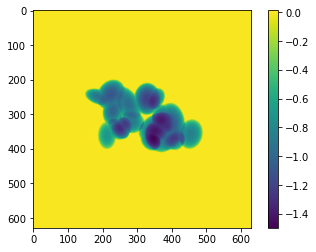

In [16]:

plt.imshow(cp.asnumpy(cp.angle(all_object[0][:][:])))
plt.colorbar()
#print("Elapsed:", end - start)


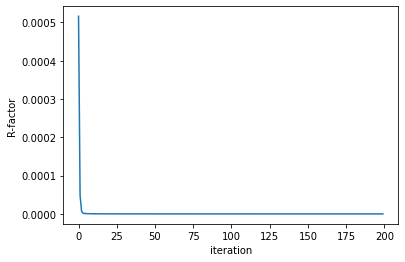

In [17]:
plt.plot(all_rfactors[0][:])
plt.xlabel("iteration")
plt.ylabel("R-factor");

In [4]:
#データの一時保存

import pickle
#f = open('all_rfactors.bin', 'wb')
#pickle.dump(all_rfactors, f)
#f.close()

#f = open('all_object.bin', 'wb')
#pickle.dump(all_object, f)
#f.close()

In [24]:
#保存データ読み込み

f = open("all_rfactors_v3.bin","rb")
all_rfactors = pickle.load(f)
f.close()

f = open("all_object_v3.bin","rb")
all_object = pickle.load(f)
f.close()

In [32]:
object_T = object.transpose()
object_mat = object_T[:,:,np.newaxis,:]

new_angle = []
for i in range (len(angle)):
    new_angle.append(int(angle[i]))

#object = 181枚画像のnp配列
arr_2d_list = [cp.array(matrix.get()) for matrix in all_object]
object =cp.array(arr_2d_list)
print(object.shape)

(181, 629, 629)


In [26]:
import scipy.io
Dictionary = {
  'object' : object_mat,
  'angle': new_angle
}
Filename = 'object_v3.mat'
scipy.io.savemat(Filename, Dictionary)

In [41]:
#FBP法を実行
#from scipy import ndimage
from cupyx.scipy import ndimage

Xsize = object.shape[2]
Ysize = object.shape[1]
Asize = object.shape[0]
ZPsize = 2024
ZPsize = max(Xsize, ZPsize)

reconst=cp.zeros([Ysize, Xsize, Xsize], dtype=np.complex128)


for Yn in tqdm(range(Ysize)):

    phimyu_g = -cp.log(object[:,:,Yn])
    phimyu_re = phimyu_g.real
    phimyu_im = phimyu_g.imag

    FT_phimyu_re = cp.fft.fftshift(cp.fft.fft(phimyu_re, n=ZPsize, axis=1))
    FT_phimyu_im = cp.fft.fftshift(cp.fft.fft(phimyu_im, n=ZPsize, axis=1))

    qx = cp.reshape(((cp.arange(1,ZPsize+1)-cp.floor(ZPsize/2))*cp.pi/ZPsize),[1, ZPsize])

    FT_phimyu_re = FT_phimyu_re*cp.abs(qx)
    FT_phimyu_im = FT_phimyu_im*cp.abs(qx)

    phimyu_re = cp.real(cp.fft.ifft(cp.fft.ifftshift(FT_phimyu_re), n=ZPsize, axis=1))
    phimyu_im = cp.real(cp.fft.ifft(cp.fft.ifftshift(FT_phimyu_im), n=ZPsize, axis=1))

    reconst_g = cp.zeros((Xsize, Xsize))

    for An in range(Asize):
        re_slice = phimyu_re[An, 0:Xsize]
        im_slice = phimyu_im[An, 0:Xsize]
        phimyu_complex = re_slice + 1j*im_slice

        phimyu_repmat = cp.tile(phimyu_complex, (Xsize,1))

        bprj = phimyu_repmat

        bprj_real=bprj.real
        bprj_imag=bprj.imag

        bprj_real_imrotate=ndimage.rotate(bprj_real, -new_angle[An], reshape=False)
        bprj_imag_imrotate=ndimage.rotate(bprj_imag, -new_angle[An], reshape=False)
        bprj_imrotate=bprj_real_imrotate + 1j*bprj_imag_imrotate

        reconst_g = reconst_g +bprj_imrotate

    

    reconst_g=reconst_g/Asize
    reconst[:,:,Yn] = reconst_g


100%|██████████| 629/629 [03:08<00:00,  3.33it/s]


In [126]:
#得られた3次元再構成画像を保存
#MATLAB Volume Viewerで読み込むことで可視化

import pickle
f = open('reconst.bin', 'wb')
pickle.dump(reconst, f)
f.close()

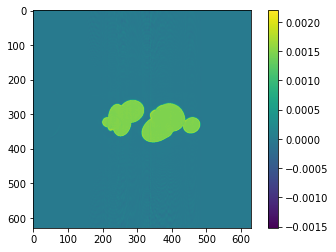

In [44]:
reconst_cp = cp.asarray(reconst)
plt.imshow(cp.asnumpy(cp.real(reconst_cp[:][:][300])))
plt.colorbar()